# 注意力机制类型

In [7]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

## 1. 加性注意力

加性注意力（Additive Attention）是最早期的注意力形式，使用前馈神经网络计算注意力权重。

计算公式：
$$\text{Attention}(q, K, V) = \sum_{i} \text{softmax}(f(q, k_i)) \cdot v_i$$
 
其中$f(q, k_i)$是一个前馈神经网络，通常实现为：
$$f(q, k_i) = v^T \tanh(W_q q + W_k k_i)$$

其中$W_q$、$W_k$是权重矩阵，$v$是输出层权重向量。


In [ ]:
class AdditiveAttention(nn.Module):
    """加性注意力（Additive Attention）实现"""
    
    def __init__(self, query_dim, key_dim, hidden_dim=64):
        super(AdditiveAttention, self).__init__()
        self.query_layer = nn.Linear(query_dim, hidden_dim, bias=False)  # 查询向量线性变换
        self.key_layer = nn.Linear(key_dim, hidden_dim, bias=False)      # 键向量线性变换
        self.energy_layer = nn.Linear(hidden_dim, 1, bias=False)         # 能量向量线性变换
        self.hidden_dim = hidden_dim    # 隐藏维度
        
    def forward(self, query, key, value, mask=None):
        """
        参数:
            query: [batch_size, query_len, query_dim]
            key: [batch_size, key_len, key_dim]
            value: [batch_size, key_len, value_dim]
            mask: [batch_size, query_len, key_len]
        返回:
            output: [batch_size, query_len, value_dim]
            attention: [batch_size, query_len, key_len]
        """
        # 获取batch_size, query_len, _ = query.size()
        batch_size, query_len, _ = query.size()
        # 获取key_len
        key_len = key.size(1)

        
        # 线性变换
        query_hidden = self.query_layer(query)  # [batch_size, query_len, hidden_dim]
        key_hidden = self.key_layer(key)        # [batch_size, key_len, hidden_dim]
        
        # 广播query以匹配key的维度
        query_hidden = query_hidden.unsqueeze(2).repeat(1, 1, key_len, 1)  # [batch_size, query_len, key_len, hidden_dim]
        key_hidden = key_hidden.unsqueeze(1).repeat(1, query_len, 1, 1)    # [batch_size, query_len, key_len, hidden_dim]
        
        # 计算注意力能量
        combined = torch.tanh(query_hidden + key_hidden)  # [batch_size, query_len, key_len, hidden_dim]
        energy = self.energy_layer(combined).squeeze(-1)  # [batch_size, query_len, key_len]
        
        # 应用掩码（如果提供）
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e9)
        
        # 计算注意力权重
        attention = F.softmax(energy, dim=-1)  # [batch_size, query_len, key_len]
        
        # 加权求和
        output = torch.bmm(attention, value)  # [batch_size, query_len, value_dim]
        
        return output, attention

In [3]:
def demonstrate_additive_attention():
    """"演示加性注意力的使用"""
    # 设置随机种子以确保结果可重现
    torch.manual_seed(42)
    
    # 创建示例数据
    batch_size = 1
    query_len = 3
    key_len = 4
    query_dim = 8
    key_dim = 8
    value_dim = 6
    
    query = torch.randn(batch_size, query_len, query_dim)
    key = torch.randn(batch_size, key_len, key_dim)
    value = torch.randn(batch_size, key_len, value_dim)
    
    # 初始化加性注意力模型
    attention = AdditiveAttention(query_dim, key_dim)
    
    # 前向传播
    output, attention_weights = attention(query, key, value)
    
    print(f"查询形状: {query.shape}")
    print(f"键形状: {key.shape}")
    print(f"值形状: {value.shape}")
    print(f"输出形状: {output.shape}")
    print(f"注意力权重形状: {attention_weights.shape}")
    
    # 可视化注意力权重
    plt.figure(figsize=(10, 6))
    plt.imshow(attention_weights[0].detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.title('Additive Attention Weight Visualization')
    plt.xticks(np.arange(key_len))
    plt.yticks(np.arange(query_len))
    plt.show()
    
    return output, attention_weights

查询形状: torch.Size([1, 3, 8])
键形状: torch.Size([1, 4, 8])
值形状: torch.Size([1, 4, 6])
输出形状: torch.Size([1, 3, 6])
注意力权重形状: torch.Size([1, 3, 4])


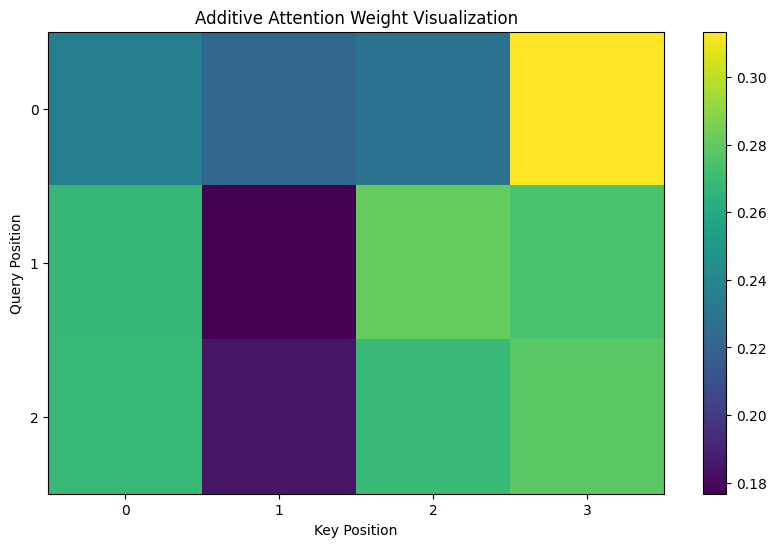

In [4]:
# 执行演示
output, attention_weights = demonstrate_additive_attention()

## 2.点积注意力 

点积注意力（Dot-Product Attention）是Transformer中使用的基础注意力形式，计算效率更高，通过矩阵乘法实现并行计算。

计算公式：
$$\text{Attention}(Q, K, V) = \text{softmax}(QK^T)V$$

其中：
- $Q$（Query）：查询矩阵
- $K$（Key）：键矩阵
- $V$（Value）：值矩阵



查询形状: torch.Size([1, 4, 8])
键形状: torch.Size([1, 6, 8])
值形状: torch.Size([1, 6, 8])
输出形状: torch.Size([1, 4, 8])
注意力权重形状: torch.Size([1, 4, 6])


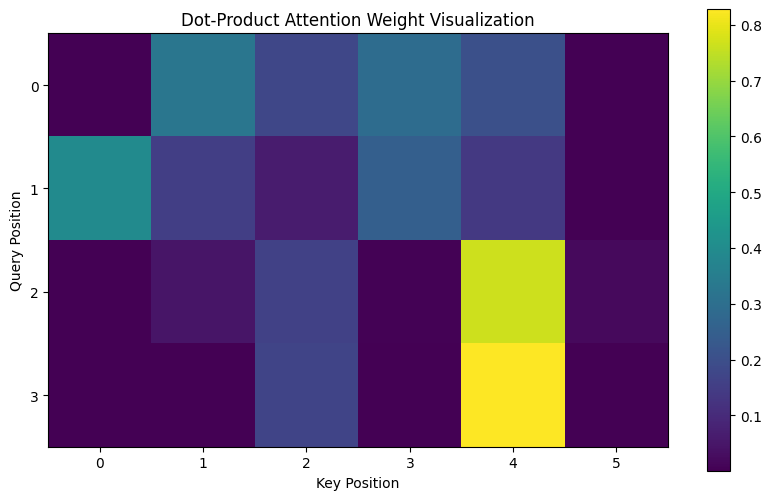

In [5]:
def dot_product_attention(query, key, value):
    """
    实现点积注意力机制
    
    参数:
        query: 查询张量 [batch_size, query_len, d_model]
        key: 键张量 [batch_size, key_len, d_model]
        value: 值张量 [batch_size, key_len, d_model]
        
    返回:
        output: 注意力输出 [batch_size, query_len, d_model]
        attention_weights: 注意力权重 [batch_size, query_len, key_len]
    """
    # 计算注意力分数 (Q * K^T)
    attention_scores = torch.matmul(query, key.transpose(-2, -1))
    
    # 应用softmax获取注意力权重
    attention_weights = F.softmax(attention_scores, dim=-1)
    
    # 应用注意力权重到值矩阵
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights

def demonstrate_dot_product_attention():
    """演示点积注意力机制的工作原理"""
    # 设置参数
    batch_size = 1
    query_len = 4
    key_len = 6
    d_model = 8
    
    # 创建随机查询、键和值
    query = torch.randn(batch_size, query_len, d_model)
    key = torch.randn(batch_size, key_len, d_model)
    value = torch.randn(batch_size, key_len, d_model)
    
    # 应用点积注意力
    output, attention_weights = dot_product_attention(query, key, value)
    
    print(f"查询形状: {query.shape}")
    print(f"键形状: {key.shape}")
    print(f"值形状: {value.shape}")
    print(f"输出形状: {output.shape}")
    print(f"注意力权重形状: {attention_weights.shape}")
    
    # 可视化注意力权重
    plt.figure(figsize=(10, 6))
    plt.imshow(attention_weights[0].detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.title('Dot-Product Attention Weight Visualization')
    plt.xticks(np.arange(key_len))
    plt.yticks(np.arange(query_len))
    plt.show()
    
    return output, attention_weights

# 执行演示
output, attention_weights = demonstrate_dot_product_attention()

## 3. 缩放点积注意力

缩放点积注意力是Transformer中使用的核心注意力机制，其计算公式为：

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

其中：
- $Q$（Query）：查询矩阵
- $K$（Key）：键矩阵
- $V$（Value）：值矩阵
- $d_k$：键向量的维度

缩放因子$\sqrt{d_k}$的引入是为了防止在高维度情况下，点积结果过大导致softmax函数梯度消失。当维度$d_k$较大时，点积$QK^T$的方差会随着维度增大而增大，导致点积值可能变得非常大或非常小。这会使softmax函数的输出接近于one-hot向量（即大部分位置的概率接近0，只有少数位置接近1），从而导致梯度消失问题。

具体来说，当两个向量的元素是独立随机变量且均值为0、方差为1时，它们的点积的方差将与向量维度$d_k$成正比。通过除以$\sqrt{d_k}$，可以将点积的方差标准化，使其不受维度大小的影响，从而保持梯度的稳定性，使模型训练更加稳定和高效。

这种缩放策略在Transformer模型中是至关重要的，特别是当模型规模扩大、维度增加时，它能有效防止训练过程中的梯度消失问题，确保模型能够正常学习长距离依赖关系。


缩放点积注意力演示:
查询形状: torch.Size([1, 4, 8])
键形状: torch.Size([1, 6, 8])
值形状: torch.Size([1, 6, 8])
输出形状: torch.Size([1, 4, 8])
注意力权重形状: torch.Size([1, 4, 6])


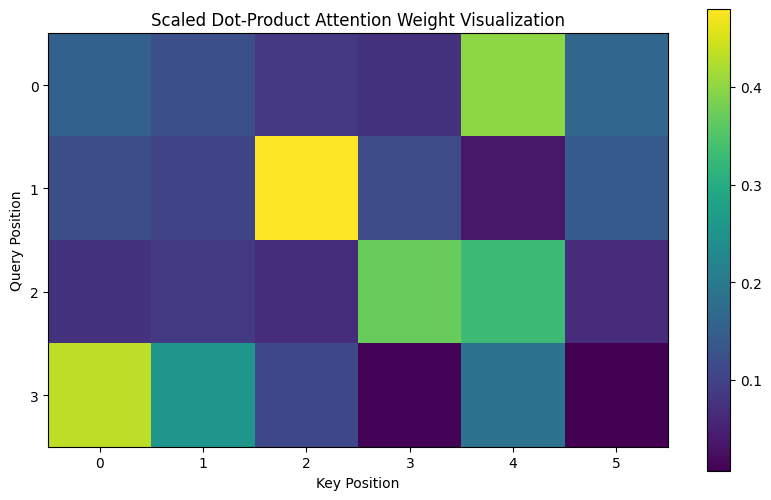

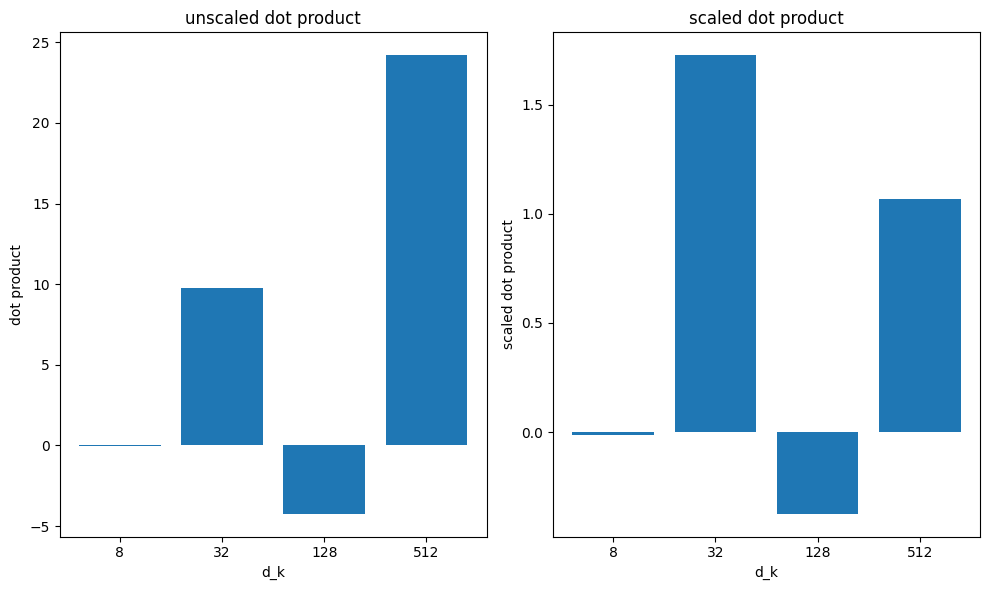

In [8]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    缩放点积注意力实现
    
    参数:
        query: 查询张量，形状为 (..., seq_len_q, depth)
        key: 键张量，形状为 (..., seq_len_k, depth)
        value: 值张量，形状为 (..., seq_len_k, depth_v)
        mask: 可选，用于遮蔽某些位置的注意力权重
        
    返回:
        output: 注意力加权后的值，形状为 (..., seq_len_q, depth_v)
        attention_weights: 注意力权重，形状为 (..., seq_len_q, seq_len_k)
    """
    # 获取维度信息
    d_k = query.shape[-1]
    
    # 计算注意力分数 (Q * K^T)
    matmul_qk = torch.matmul(query, key.transpose(-2, -1))
    
    # 缩放注意力分数
    scaled_attention_logits = matmul_qk / math.sqrt(d_k)
    
    # 应用掩码（如果提供）
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    # 应用softmax获取注意力权重
    attention_weights = F.softmax(scaled_attention_logits, dim=-1)
    
    # 计算输出
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights

def demonstrate_scaled_dot_product_attention():
    """演示缩放点积注意力的计算过程"""
    # 设置参数
    batch_size = 1
    query_len = 4
    key_len = 6
    d_model = 8
    
    # 创建随机查询、键和值
    query = torch.randn(batch_size, query_len, d_model)
    key = torch.randn(batch_size, key_len, d_model)
    value = torch.randn(batch_size, key_len, d_model)
    
    # 计算缩放点积注意力
    output, attention_weights = scaled_dot_product_attention(query, key, value)
    
    # 打印形状信息
    print("缩放点积注意力演示:")
    print(f"查询形状: {query.shape}")
    print(f"键形状: {key.shape}")
    print(f"值形状: {value.shape}")
    print(f"输出形状: {output.shape}")
    print(f"注意力权重形状: {attention_weights.shape}")
    
    # 可视化注意力权重
    plt.figure(figsize=(10, 6))
    plt.imshow(attention_weights[0].detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.title('Scaled Dot-Product Attention Weight Visualization')
    plt.xticks(np.arange(key_len))
    plt.yticks(np.arange(query_len))
    plt.show()
    
    # 比较不同维度下的缩放效果
    dims = [8, 32, 128, 512]
    plt.figure(figsize=(10, 6))
    
    for i, dim in enumerate(dims):
        # 创建随机查询和键
        q = torch.randn(1, 1, dim)
        k = torch.randn(1, 1, dim)
        
        # 计算点积
        dot_product = torch.matmul(q, k.transpose(-2, -1))
        
        # 计算缩放点积
        scaled_dot_product = dot_product / math.sqrt(dim)
        
        # 收集结果
        if i == 0:
            dot_products = [dot_product.item()]
            scaled_dot_products = [scaled_dot_product.item()]
        else:
            dot_products.append(dot_product.item())
            scaled_dot_products.append(scaled_dot_product.item())
    
    # 绘制比较图
    plt.subplot(1, 2, 1)
    plt.bar(range(len(dims)), dot_products)
    plt.xticks(range(len(dims)), [str(d) for d in dims])
    plt.xlabel('d_k')
    plt.ylabel("dot product")
    plt.title('unscaled dot product')
    
    plt.subplot(1, 2, 2)
    plt.bar(range(len(dims)), scaled_dot_products)
    plt.xticks(range(len(dims)), [str(d) for d in dims])
    plt.xlabel('d_k')
    plt.ylabel("scaled dot product")
    plt.title('scaled dot product')
    
    plt.tight_layout()
    plt.show()
    
    return output, attention_weights

# 执行演示
output, attention_weights = demonstrate_scaled_dot_product_attention()

## 4. 稀疏注意力 

稀疏注意力是为了解决标准注意力机制在处理长序列时的计算复杂度问题（O(n²)）而提出的。
主要思想是只计算部分位置之间的注意力权重，而不是所有位置对之间的权重。

主要类型包括：
1. 固定模式稀疏注意力：如Sparse Transformer，在固定步长的位置上计算注意力
2. 局部窗口注意力：如Longformer，每个token只关注周围固定窗口内的其他token
3. 随机稀疏注意力：如BigBird，随机选择部分位置进行注意力计算

稀疏注意力可以将复杂度从O(n²)降至O(n log n)或O(n)，使模型能够处理更长的序列。



### 4.1 Sparse Transformer

Sparse Transformer是OpenAI在2019年提出的一种稀疏注意力机制，它通过固定模式的稀疏连接来降低计算复杂度。

主要特点：
1. 将注意力矩阵分解为固定模式的稀疏块
2. 每个位置只与特定步长的位置计算注意力
3. 结合了局部注意力和跨距注意力（strided attention）
4. 将复杂度从O(n²)降至O(n√n)

Sparse Transformer在图像生成、音频合成和文本处理等任务中表现出色，特别适合处理长序列数据。


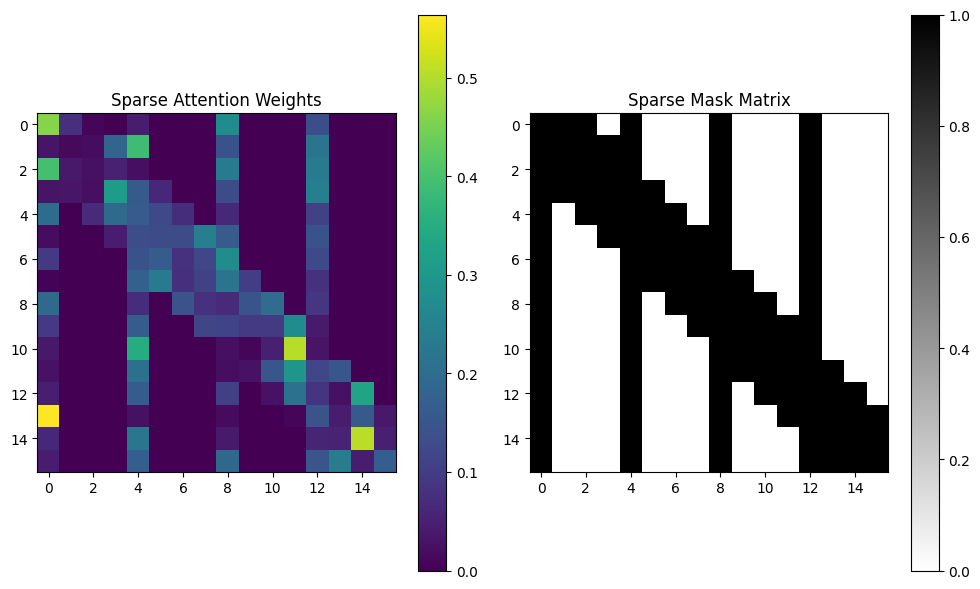

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def sparse_attention(q, k, v, block_size=4, strided_size=2, mask=None):
    """
    实现Sparse Transformer的稀疏注意力机制
    
    参数:
    - q, k, v: 查询、键、值矩阵
    - block_size: 局部注意力的块大小
    - strided_size: 跨距注意力的步长
    - mask: 可选的掩码
    
    返回:
    - output: 注意力的输出
    - attention_weights: 注意力权重
    """
    # 获取维度
    seq_len = q.shape[1]
    
    # 创建稀疏注意力掩码
    sparse_mask = np.zeros((seq_len, seq_len))
    
    # 1. 局部注意力 - 每个token关注其周围block_size范围内的token
    for i in range(seq_len):
        start = max(0, i - block_size // 2)
        end = min(seq_len, i + block_size // 2 + 1)
        sparse_mask[i, start:end] = 1
    
    # 2. 跨距注意力 - 每个token关注间隔strided_size的token
    for i in range(seq_len):
        for j in range(0, seq_len, strided_size):
            sparse_mask[i, j] = 1
    
    # 转换为PyTorch张量
    sparse_mask = torch.tensor(sparse_mask, dtype=torch.float32)
    
    # 计算注意力分数
    matmul_qk = torch.matmul(q, k.transpose(-2, -1))
    
    # 缩放
    dk = k.size()[-1]
    scaled_attention_logits = matmul_qk / (dk ** 0.5)
    
    # 应用稀疏掩码
    sparse_mask = sparse_mask.reshape(1, 1, seq_len, seq_len)
    scaled_attention_logits = scaled_attention_logits * sparse_mask + (1 - sparse_mask) * -1e9
    
    # 如果提供了额外的掩码，也应用它
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    # 应用softmax获取注意力权重
    attention_weights = torch.nn.functional.softmax(scaled_attention_logits, dim=-1)
    
    # 计算输出
    output = torch.matmul(attention_weights, v)
    
    return output, attention_weights, sparse_mask

def demonstrate_sparse_attention():
    """演示稀疏注意力机制的效果"""
    seq_len = 16
    d_model = 8
    
    # 创建随机查询、键、值矩阵
    q = torch.randn(1, seq_len, d_model)
    k = torch.randn(1, seq_len, d_model)
    v = torch.randn(1, seq_len, d_model)
    
    # 应用稀疏注意力
    output, attention_weights, sparse_mask = sparse_attention(q, k, v, block_size=4, strided_size=4)
    
    # 可视化注意力权重和掩码矩阵
    plt.figure(figsize=(10, 6))
    
    # 稀疏注意力权重
    plt.subplot(1, 2, 1)
    attention_weights_squeezed = attention_weights.squeeze(0).squeeze(0).detach().numpy()
    plt.imshow(attention_weights_squeezed, cmap='viridis')
    plt.title("Sparse Attention Weights")
    plt.colorbar()
    
    # 稀疏掩码矩阵
    plt.subplot(1, 2, 2)
    sparse_mask_squeezed = sparse_mask.squeeze(0).squeeze(0).numpy()
    plt.imshow(sparse_mask_squeezed, cmap='binary')
    plt.title("Sparse Mask Matrix")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    return output, attention_weights

# 执行演示
output, attention_weights = demonstrate_sparse_attention()


### 4.2 longformer

Longformer是一种专为长文本处理设计的注意力机制，它结合了局部窗口注意力和全局注意力。通过这种方式，Longformer能够在保持线性计算复杂度的同时，有效处理长序列文本。其核心思想是对每个token只关注其周围固定窗口大小的token以及少量特殊的全局token，从而减少计算量并保持模型对长距离依赖的建模能力。这些特殊的全局token通常是通过任务特定的方式选择的，例如在分类任务中可以选择[CLS]标记作为全局token，在问答任务中可以将问题中的所有token设为全局token，或者通过注意力机制自动学习哪些token应该具有全局视野。这种设计使得模型能够在处理长文本时既关注局部上下文，又能捕捉到文档级别的全局信息。

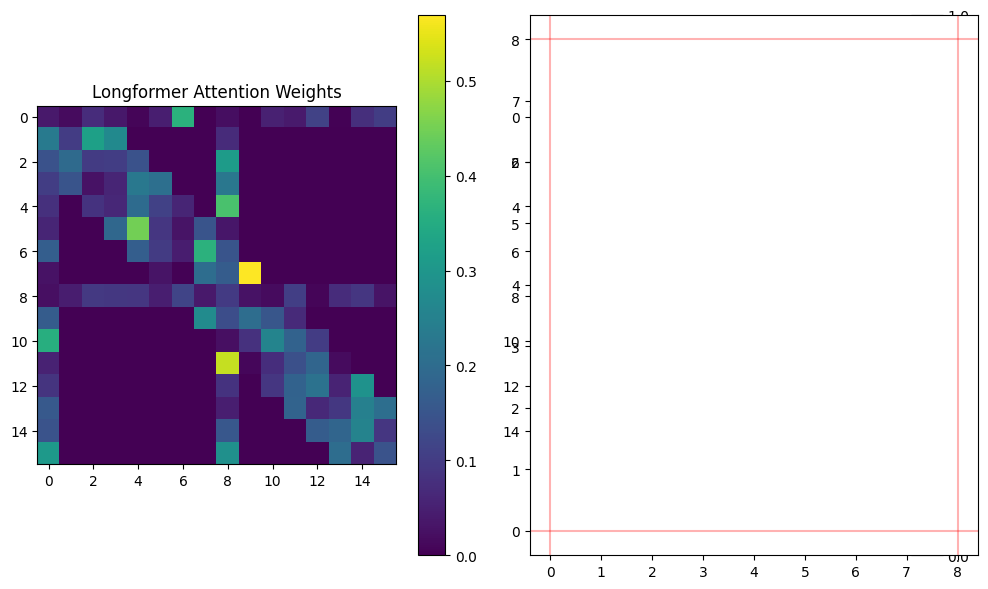

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def longformer_attention(q, k, v, w=3, global_tokens=None, mask=None):
    """
    实现Longformer注意力机制
    
    参数:
        q, k, v: 查询、键、值矩阵
        w: 窗口大小，表示每个token关注其左右各w个token
        global_tokens: 全局token的索引列表，这些token会关注所有token
        mask: 可选的掩码矩阵
    
    返回:
        output: 注意力计算的输出
        attention_weights: 注意力权重
        attention_mask: 注意力掩码
    """
    batch_size, seq_len, d_model = q.size()
    
    # 创建滑动窗口掩码
    attention_mask = torch.zeros(seq_len, seq_len, device=q.device)
    
    # 为每个位置设置窗口注意力
    for i in range(seq_len):
        start = max(0, i - w)
        end = min(seq_len, i + w + 1)
        attention_mask[i, start:end] = 1
    
    # 设置全局token的注意力
    if global_tokens is not None:
        for idx in global_tokens:
            # 全局token关注所有token
            attention_mask[idx, :] = 1
            # 所有token关注全局token
            attention_mask[:, idx] = 1
    
    # 计算注意力分数
    scores = torch.matmul(q, k.transpose(-2, -1)) / (d_model ** 0.5)
    
    # 应用掩码
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # 应用Longformer掩码
    attention_mask = attention_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, seq_len]
    scores = scores.masked_fill(attention_mask == 0, -1e9)
    
    # 计算注意力权重
    attention_weights = F.softmax(scores, dim=-1)
    
    # 计算输出
    output = torch.matmul(attention_weights, v)
    
    return output, attention_weights, attention_mask

def demonstrate_longformer_attention():
    """演示Longformer注意力机制"""
    seq_len = 16
    d_model = 8
    window_size = 2
    
    # 创建随机查询、键、值矩阵
    q = torch.randn(1, seq_len, d_model)
    k = torch.randn(1, seq_len, d_model)
    v = torch.randn(1, seq_len, d_model)
    
    # 设置全局token索引
    global_tokens = [0, 8]  # 第一个和中间的token作为全局token
    
    # 应用Longformer注意力
    output, attention_weights, attention_mask = longformer_attention(
        q, k, v, w=window_size, global_tokens=global_tokens
    )
    
    # 可视化注意力权重和掩码矩阵
    plt.figure(figsize=(10, 6))
    
    # Longformer注意力权重
    plt.subplot(1, 2, 1)
    attention_weights_squeezed = attention_weights.squeeze(0).squeeze(0).detach().numpy()
    plt.imshow(attention_weights_squeezed, cmap='viridis')
    plt.title("Longformer Attention Weights")
    plt.colorbar()
    
    # Longformer掩码矩阵
    plt.subplot(1, 2, 2)
    attention_mask_squeezed = attention_mask.squeeze(0).squeeze(0).numpy()
    plt.imshow(attention_mask_squeezed, cmap='binary')
    plt.title("Longformer Attention Mask")
    plt.colorbar()
    
    # 标记全局token
    for idx in global_tokens:
        plt.subplot(1, 2, 2)
        plt.axhline(y=idx, color='r', linestyle='-', alpha=0.3)
        plt.axvline(x=idx, color='r', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return output, attention_weights

# 执行演示
output, attention_weights = demonstrate_longformer_attention()


### BigBird 

BigBird是Google在2020年提出的一种稀疏注意力机制，它结合了三种注意力模式：
1. 全局注意力：特定的全局token可以关注所有token，所有token也可以关注这些全局token
2. 窗口注意力：每个token关注其周围固定窗口大小内的token
3. 随机注意力：每个token随机关注一些其他token

BigBird通过这种混合注意力机制，将注意力复杂度从O(n²)降低到O(n)，同时保持了模型性能。
它特别适合处理长序列文档、基因组等长文本数据。

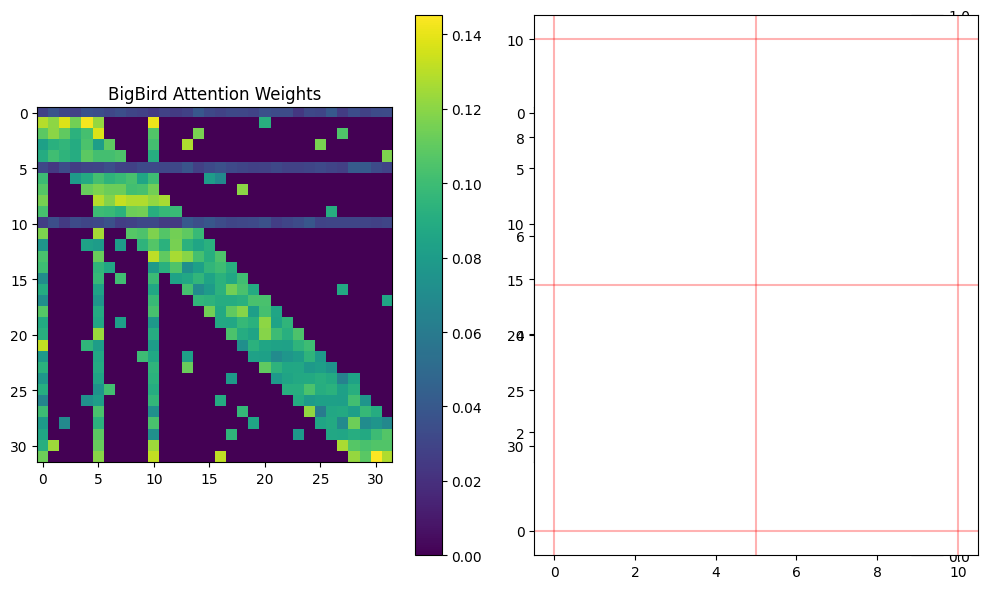

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

class BigBirdAttention(nn.Module):
    def __init__(self, hidden_size=512, num_attention_heads=8, block_size=64, num_random_blocks=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.block_size = block_size
        self.num_random_blocks = num_random_blocks
        self.attention_head_size = hidden_size // num_attention_heads
        
        # 定义查询、键、值的线性变换
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, hidden_size)
        
    def transpose_for_scores(self, x):
        # 重塑张量以便进行多头注意力计算
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
    
    def create_bigbird_attention_mask(self, seq_length, global_tokens, window_size=3):
        # 创建BigBird稀疏注意力掩码
        attention_mask = torch.zeros(seq_length, seq_length)
        
        # 1. 全局注意力
        for idx in global_tokens:
            # 全局token关注所有token
            attention_mask[idx, :] = 1
            # 所有token关注全局token
            attention_mask[:, idx] = 1
        
        # 2. 窗口注意力
        for i in range(seq_length):
            window_start = max(0, i - window_size)
            window_end = min(seq_length, i + window_size + 1)
            attention_mask[i, window_start:window_end] = 1
        
        # 3. 随机注意力
        for i in range(seq_length):
            if i in global_tokens:
                continue  # 全局token已经有全局注意力
            # 为每个非全局token随机选择几个其他token关注
            random_indices = torch.randperm(seq_length)[:self.num_random_blocks]  # 随机选择几个其他token关注
            attention_mask[i, random_indices] = 1
        
        return attention_mask
    
    def forward(self, hidden_states, attention_mask=None, global_tokens=None):
        seq_length = hidden_states.size(1)
        
        # 如果没有提供全局token，默认第一个token为全局token
        if global_tokens is None:
            global_tokens = [0]
        
        # 如果没有提供注意力掩码，创建BigBird稀疏注意力掩码
        if attention_mask is None:
            attention_mask = self.create_bigbird_attention_mask(seq_length, global_tokens)
            attention_mask = attention_mask.unsqueeze(0).unsqueeze(0)
        
        # 线性变换
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)
        
        # 转换形状以便进行多头注意力计算
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)
        
        # 计算注意力分数
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / (self.attention_head_size ** 0.5)
        
        # 应用注意力掩码
        if attention_mask is not None:
            # 确保掩码形状与注意力分数匹配
            if attention_mask.dim() == 2:
                attention_mask = attention_mask.unsqueeze(0).unsqueeze(0)
                attention_mask = attention_mask.expand(attention_scores.size(0), self.num_attention_heads, -1, -1)
            
            # 将掩码中的0变为大的负值，使softmax后接近0
            attention_scores = attention_scores.masked_fill(attention_mask == 0, -10000.0)
        
        # 应用softmax获取注意力权重
        attention_probs = F.softmax(attention_scores, dim=-1)
        
        # 应用注意力权重到值上
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        
        # 重塑回原始形状
        new_context_layer_shape = context_layer.size()[:-2] + (self.hidden_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        
        # 最终的线性变换
        output = self.output(context_layer)
        
        return output, attention_probs

def demonstrate_bigbird_attention():
    # 设置参数
    hidden_size = 512 # 隐藏层大小
    num_attention_heads = 8 # 注意力头数
    seq_length = 32 # 序列长度
    batch_size = 1 # 批次大小
    
    # 创建随机输入
    hidden_states = torch.randn(batch_size, seq_length, hidden_size) 
    
    # 定义全局token
    global_tokens = [0, 5, 10]  # 第1个、第6个和第11个token为全局token
    
    # 初始化BigBird注意力层
    bigbird_attention = BigBirdAttention(
        hidden_size=hidden_size,
        num_attention_heads=num_attention_heads,
        block_size=4,
        num_random_blocks=2
    )
    
    # 创建BigBird注意力掩码
    attention_mask = bigbird_attention.create_bigbird_attention_mask(seq_length, global_tokens)
    
    # 前向传播
    output, attention_weights = bigbird_attention(hidden_states, attention_mask.unsqueeze(0).unsqueeze(0), global_tokens)
    
    # 可视化注意力权重和掩码
    plt.figure(figsize=(10, 6))
    
    # BigBird注意力权重
    plt.subplot(1, 2, 1)
    attention_weights_squeezed = attention_weights.squeeze(0).mean(0).detach().numpy()
    plt.imshow(attention_weights_squeezed, cmap='viridis')
    plt.title("BigBird Attention Weights")
    plt.colorbar()
    
    # BigBird掩码矩阵
    plt.subplot(1, 2, 2)
    plt.imshow(attention_mask.numpy(), cmap='binary')
    plt.title("BigBird Attention Mask")
    plt.colorbar()
    
    # 标记全局token
    for idx in global_tokens:
        plt.subplot(1, 2, 2)
        plt.axhline(y=idx, color='r', linestyle='-', alpha=0.3)
        plt.axvline(x=idx, color='r', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return output, attention_weights

# 执行演示
output, attention_weights = demonstrate_bigbird_attention()